In [1]:
import pickle
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
import matplotlib.cm as cm
from sklearn.cluster import DBSCAN
from tqdm.notebook import tqdm
from google.colab import drive
from gensim import corpora
import gensim

In [2]:
def get_topics(df_data, labels):
  topics = {}

  for k in list(set(labels)):
    df_filtered = df_data[labels == k]  
    texts = df_filtered['tokens'].to_numpy()

    # create dictionary
    dictionary = corpora.Dictionary(texts)
    
    # create BOW
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    # number of topics
    num_topics = 1
    
    # Build LDA model
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                      id2word=dictionary,
                                      num_topics=num_topics)

    res = lda_model.get_topic_terms(0,5)
    topics[k] = (str(k) + " - " + dictionary[res[0][0]] + " " + dictionary[res[1][0]] + " " + dictionary[res[2][0]] + " " + dictionary[res[3][0]] + " " + dictionary[res[4][0]]).replace(",", "").replace(";", "")
  return topics

def load_obj(path):
  with open(path, 'rb') as f:
    return pickle.load(f)

def very_special_tokenizer(text):
  return text

def load(path):
  classes = ['ABD','ACML','ANLP','DA','DM','Exams','Incognito','Information','IRTM','Library','LP','MAI 1','MAI 2','MIDF','MM','MS','NM','General','Project - 2-2','PS','Schedules and Deadlines','SIP','Social','Social Dutch','Submissions','TCS','UMNews','UMSports']

  documents_train = load_obj(path+'/documents_train.pkl')
  documents_test = load_obj(path+'/documents_test.pkl')

  df_train = pd.DataFrame.from_dict(documents_train, orient='index').drop(['fixed', 'vector'],axis=1)
  df_test = pd.DataFrame.from_dict(documents_test, orient='index').drop(['fixed', 'vector'],axis=1)

  tokenized_text =  np.concatenate((df_train['tokens'].to_numpy(), df_test['tokens'].to_numpy()), axis=0) 

  tfidf = TfidfVectorizer(tokenizer=very_special_tokenizer, lowercase=False, sublinear_tf=True)
  tfidf.fit(tokenized_text)

  X_train = tfidf.transform(df_train['tokens'].to_numpy())
  y_train = df_train['class'].to_numpy()

  X_test = tfidf.transform(df_test['tokens'].to_numpy())
  y_test = df_test['class'].to_numpy()

  
  return df_train, df_test, X_train, X_test, y_train, y_test, classes

In [3]:
df_train, df_test, X_train, X_test, y_train, y_test, classes = load('drive/MyDrive/IRTM/data')

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


# Begin Clustering

In [4]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
from matplotlib import pyplot as plt

In [5]:
def find_optimal_clusters_k_means(X, max_k):
    iters = range(2, max_k+1, 1)
    
    silhouette = []
    sse = []
    for k in iters:
        clf = MiniBatchKMeans(n_clusters=k, random_state=20)
        labels = clf.fit_predict(X)
        silhouette.append( silhouette_score(X, labels))
        sse.append(clf.inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1, figsize=(20, 6))
    ax.plot(iters, silhouette, marker='o')
    ax.set_xlabel('No. Clusters')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('Silhouhette Score')
    ax.set_title('Silhouhette Score by Clusters Plot')
    plt.show()
        
    f, ax = plt.subplots(1, 1, figsize=(20, 6))
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('No. Clusters')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Clusters Plot')
    plt.show()

In [6]:
def find_optimal_clusters_agglomerative(X, max_k):
    iters = range(2, max_k+1, 1)
    
    silhouette1 = []
    silhouette2 = []
    silhouette3 = []
    silhouette4 = []

    for k in iters:
        labels = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward').fit_predict(X_train.todense())
        silhouette1.append( silhouette_score(X, labels))
        labels = AgglomerativeClustering(n_clusters=k, affinity='cosine', linkage='average').fit_predict(X_train.todense())
        silhouette2.append( silhouette_score(X, labels))
        labels = AgglomerativeClustering(n_clusters=k, affinity='cosine', linkage='complete').fit_predict(X_train.todense())
        silhouette3.append( silhouette_score(X, labels))
        labels = AgglomerativeClustering(n_clusters=k, affinity='cosine', linkage='single').fit_predict(X_train.todense())
        silhouette4.append( silhouette_score(X, labels))
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1, figsize=(20, 6))
    ax.plot(iters, silhouette1, marker='o')
    ax.set_xlabel('No. Clusters')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('Silhouhette Score')
    ax.set_title('Silhouhette Score by Clusters Plot Ward')
    plt.show()

    f, ax = plt.subplots(1, 1, figsize=(20, 6))
    ax.plot(iters, silhouette2, marker='o')
    ax.set_xlabel('No. Clusters')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('Silhouhette Score')
    ax.set_title('Silhouhette Score by Clusters Plot Average')
    plt.show()

    f, ax = plt.subplots(1, 1, figsize=(20, 6))
    ax.plot(iters, silhouette3, marker='o')
    ax.set_xlabel('No. Clusters')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('Silhouhette Score')
    ax.set_title('Silhouhette Score by Clusters Plot Complete')
    plt.show()

    f, ax = plt.subplots(1, 1, figsize=(20, 6))
    ax.plot(iters, silhouette4, marker='o')
    ax.set_xlabel('No. Clusters')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('Silhouhette Score')
    ax.set_title('Silhouhette Score by Clusters Plot Single')
    plt.show()

In [7]:
def plot_tsne_pca_lda(data, labels, names):
    pca = PCA(n_components=2).fit_transform(data.todense())
    tsne = TSNE(n_components=2).fit_transform(PCA().fit_transform(data.todense()))
    
    f, ax = plt.subplots(1, 2, figsize=(30, 15))

    for label in np.unique(labels):
        ax[0].scatter(pca[labels==label, 0], pca[labels==label, 1], label=names[label])
    ax[0].set_title('PCA Cluster Plot')
    ax[0].legend(loc='upper right', ncol=2)

    for label in np.unique(labels):
        ax[1].scatter(tsne[labels==label, 0], tsne[labels==label, 1], label=names[label])
    ax[1].set_title('TSNE Cluster Plot')
    ax[1].legend(loc='lower right', ncol=2)

    plt.show()

In [8]:
def plot_tsne_pca_lda_3d(data, labels, names):
    pca = PCA(n_components=3).fit_transform(data.todense())
    tsne = TSNE(n_components=3).fit_transform(PCA().fit_transform(data.todense()))
    
    fig = plt.figure(figsize=(30, 15))

    ax1 = fig.add_subplot(121, projection='3d')
    for label in np.unique(labels):
      ax1.scatter(pca[labels==label, 0], pca[labels==label, 1], pca[labels==label, 2], label=names[label])
    ax1.legend(ncol=2)
    ax1.set_title('PCA Cluster Plot')

    ax2 = ax1 = fig.add_subplot(122, projection='3d')
    for label in np.unique(labels):
      ax2.scatter(tsne[labels==label, 0], tsne[labels==label, 1], tsne[labels==label, 2], label=names[label])
    ax2.legend(ncol=2)
    ax2.set_title('TSNE Cluster Plot')
    plt.show()

In [ ]:
def find_optimal_clusters_dbscan(X):
    cluster = []
    error = []
    for eps in tqdm(np.arange(0.01, 2, 0.005)):
        clusters = DBSCAN(eps=eps, min_samples=5, metric='cosine').fit_predict(X)
        cluster.append(len(set(clusters)))
        error.append(len(clusters[clusters == -1]))

    plt.figure(figsize=(10,8))
    plt.plot(np.arange(0.01, 2, 0.005), cluster)
    plt.xlabel("eps-Value")
    plt.ylabel('# Classes')
    plt.show()
    plt.figure(figsize=(10,8))
    plt.plot(np.arange(0.01, 2, 0.005), error)
    plt.xlabel("eps-Value")
    plt.ylabel('# Outliers')
    plt.show()

Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters
Fit 17 clusters
Fit 18 clusters
Fit 19 clusters
Fit 20 clusters
Fit 21 clusters
Fit 22 clusters
Fit 23 clusters
Fit 24 clusters
Fit 25 clusters
Fit 26 clusters
Fit 27 clusters
Fit 28 clusters
Fit 29 clusters
Fit 30 clusters
Fit 31 clusters
Fit 32 clusters
Fit 33 clusters
Fit 34 clusters
Fit 35 clusters
Fit 36 clusters
Fit 37 clusters
Fit 38 clusters
Fit 39 clusters
Fit 40 clusters
Fit 41 clusters
Fit 42 clusters
Fit 43 clusters
Fit 44 clusters
Fit 45 clusters
Fit 46 clusters
Fit 47 clusters
Fit 48 clusters
Fit 49 clusters
Fit 50 clusters


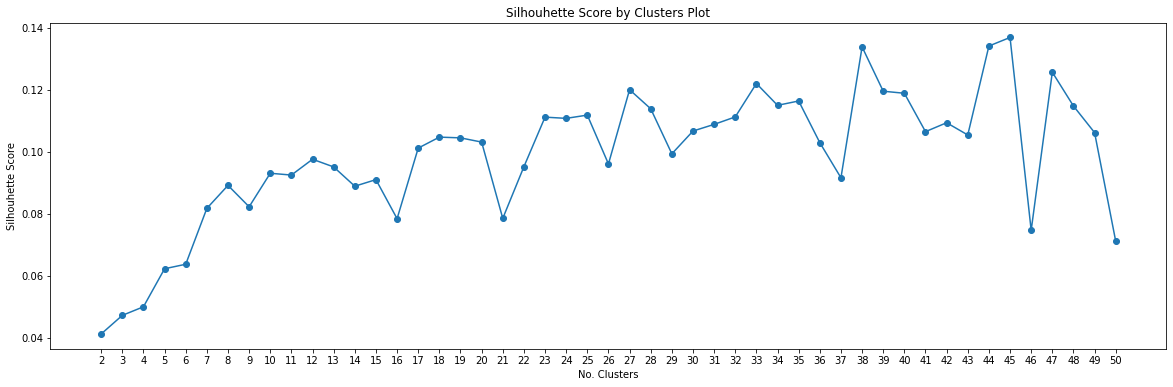

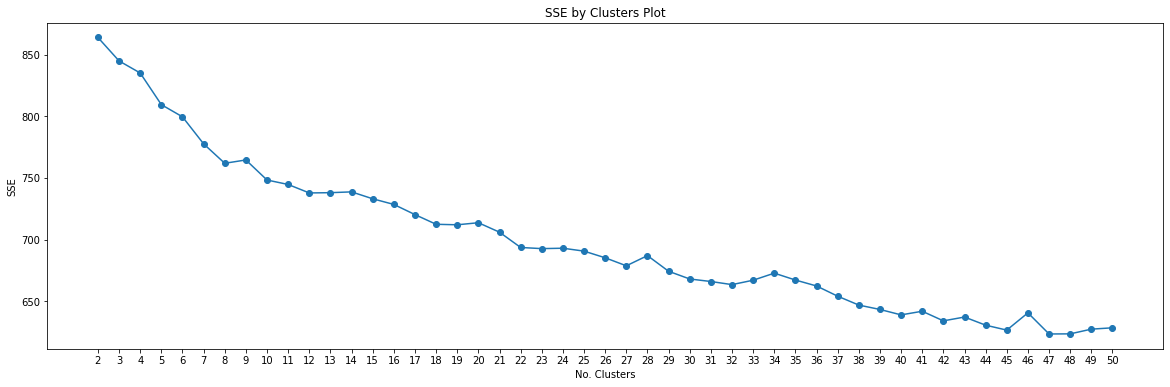

In [ ]:
find_optimal_clusters_k_means(X_train, 50)

In [ ]:
clf = KMeans(n_clusters=45, random_state=20)
labels = clf.fit_predict(X_train)

In [ ]:
adjusted_rand_score(y_train, labels)

0.2378291533358933

In [ ]:
names = list(get_topics(df_train, labels).values())
class_labels = [list(set([classes[x] for x in df_train[labels==k]['class'].values])) for k in list(set(labels))]
for i in range(45): print(names[i], class_labels[i])

0 - evaluate dke-iwio@maastrichtuniversity.nl please quality programme ['Not Important']
1 - submission receive id coursework 2019 ['Submissions']
2 - bonus 2020 time 2019 exam ['MS', 'Project - 2-2', 'NM', 'TCS', 'LP', 'DA']
3 - exam student course take time ['MIDF', 'Project - 2-2', 'Not Important', 'Social', 'LP', 'Information', 'Exams', 'DA']
4 - learning assignment machine grade notification ['ACML', 'Not Important']
5 - lab room data mining notifications@instructure.com ['DM']
6 - appeal exam decision maastricht address ['Exams']
7 - dke student master programme session ['Information', 'Not Important', 'Schedules and Deadlines', 'Social']
8 - project group merlin.koehler@student.maastrichtuniversity.nl presentation student ['ANLP', 'MAI', 'Project - 2-2', 'UMSports', 'Information', 'IRTM']
9 - 20 group dke bianca stud ['MAI']
10 - canvas reply message evgueni please ['SIP', 'DM', 'MAI']
11 - board incognito poster like send ['Not Important', 'Incognito']
12 - student survey natio

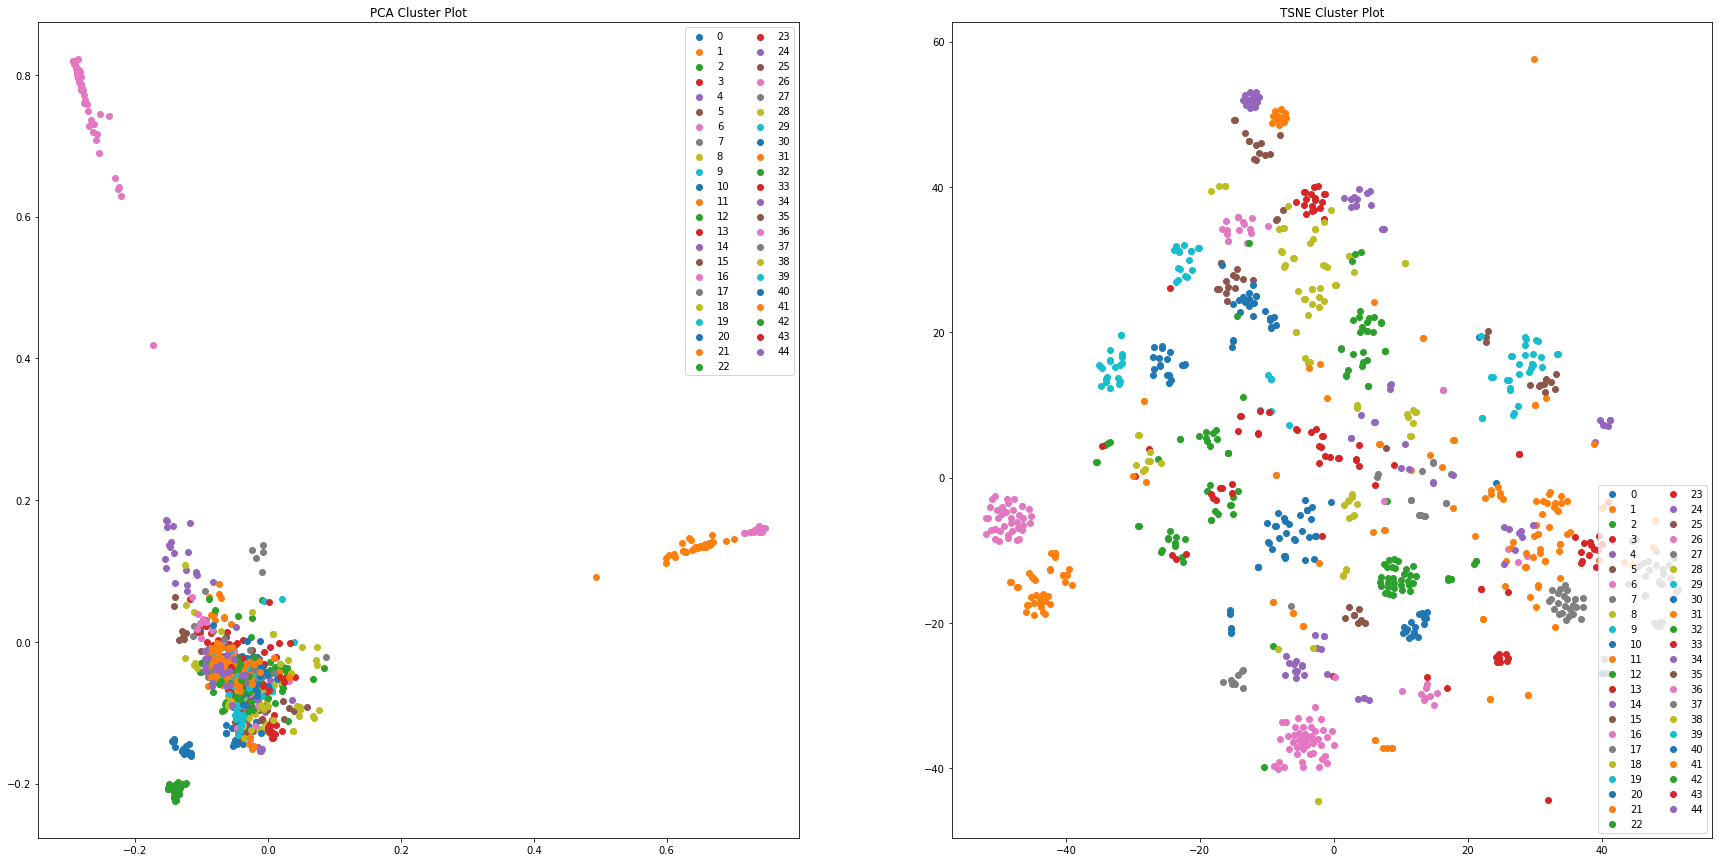

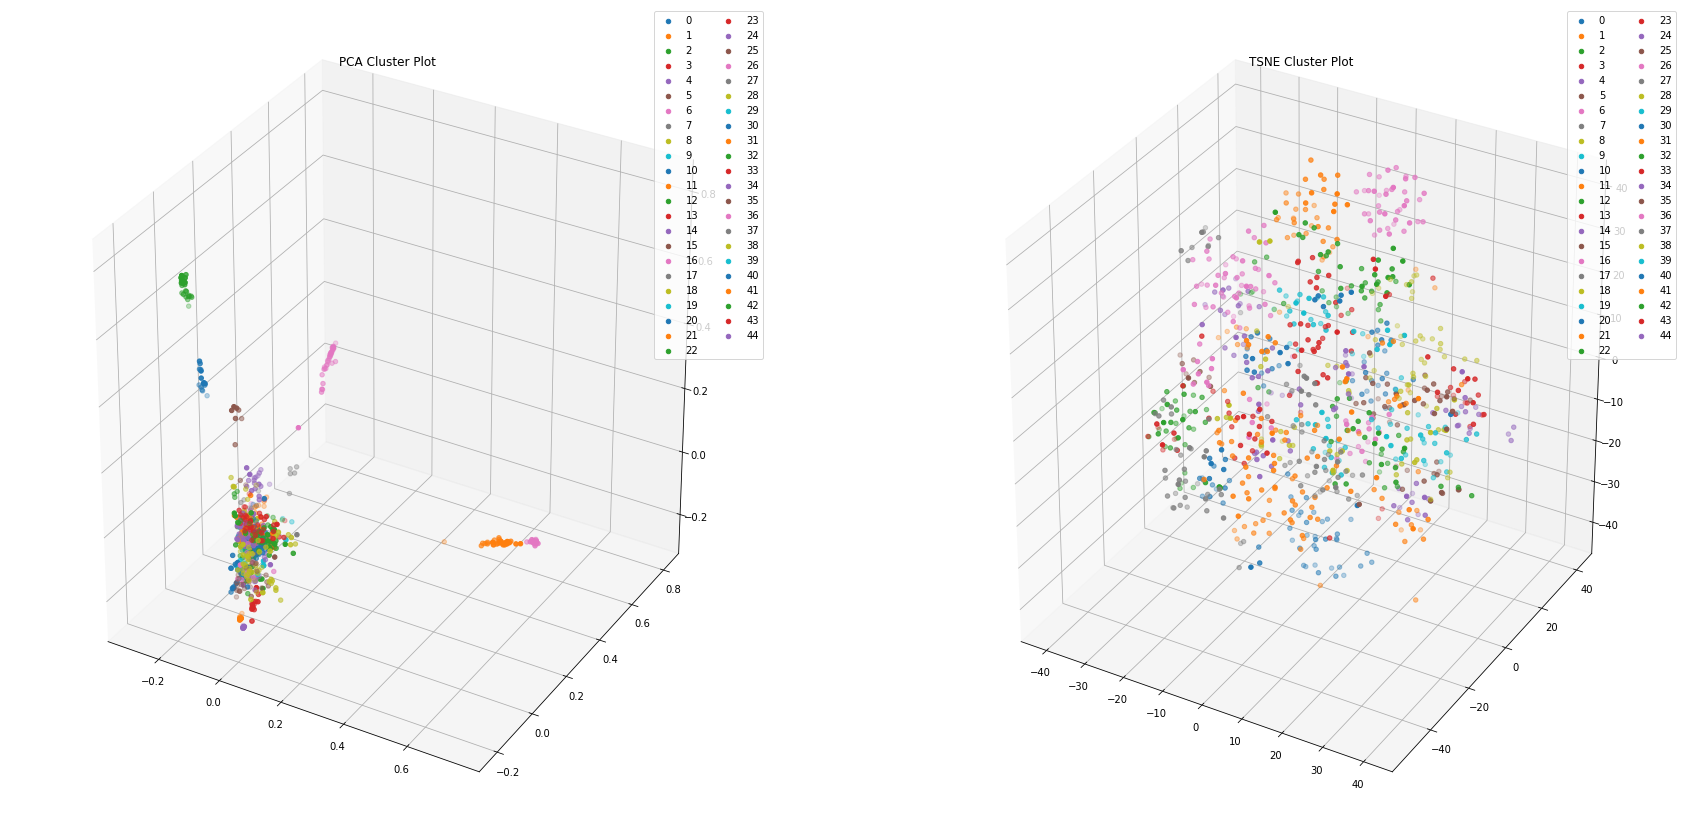

In [ ]:
plot_tsne_pca_lda(X_train, labels, list(set(labels)))
plot_tsne_pca_lda_3d(X_train, labels, list(set(labels)))

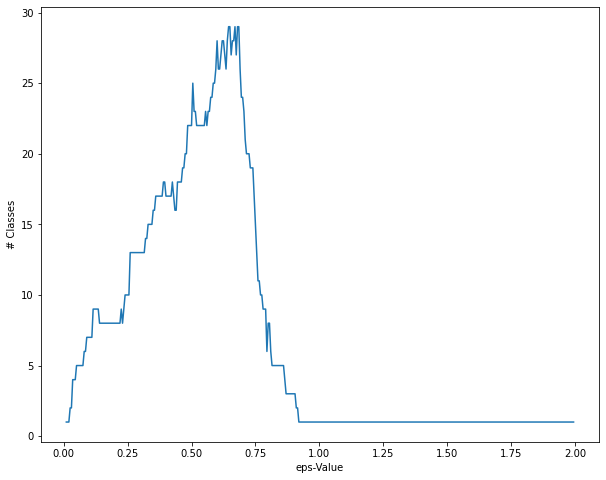

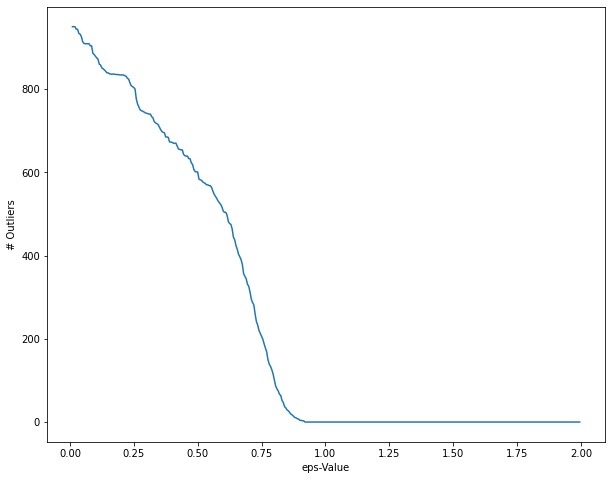

In [ ]:
find_optimal_clusters_dbscan(X_train)

In [ ]:
labels = DBSCAN(eps=.68, min_samples=5, metric='cosine').fit_predict(X_train)
set(labels)

{-1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27}

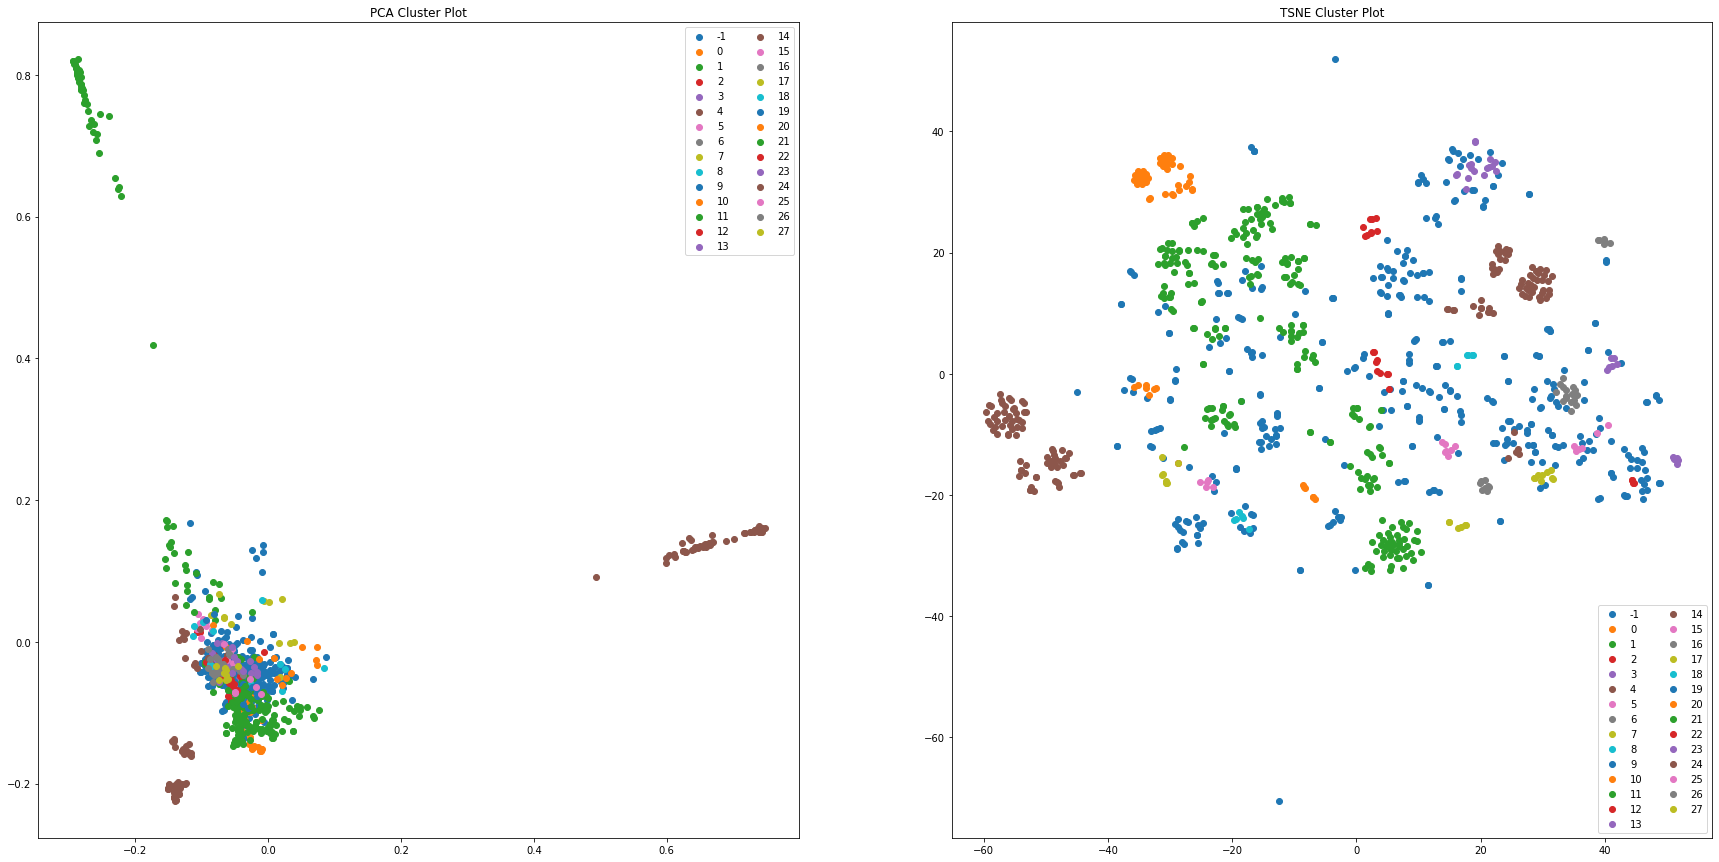

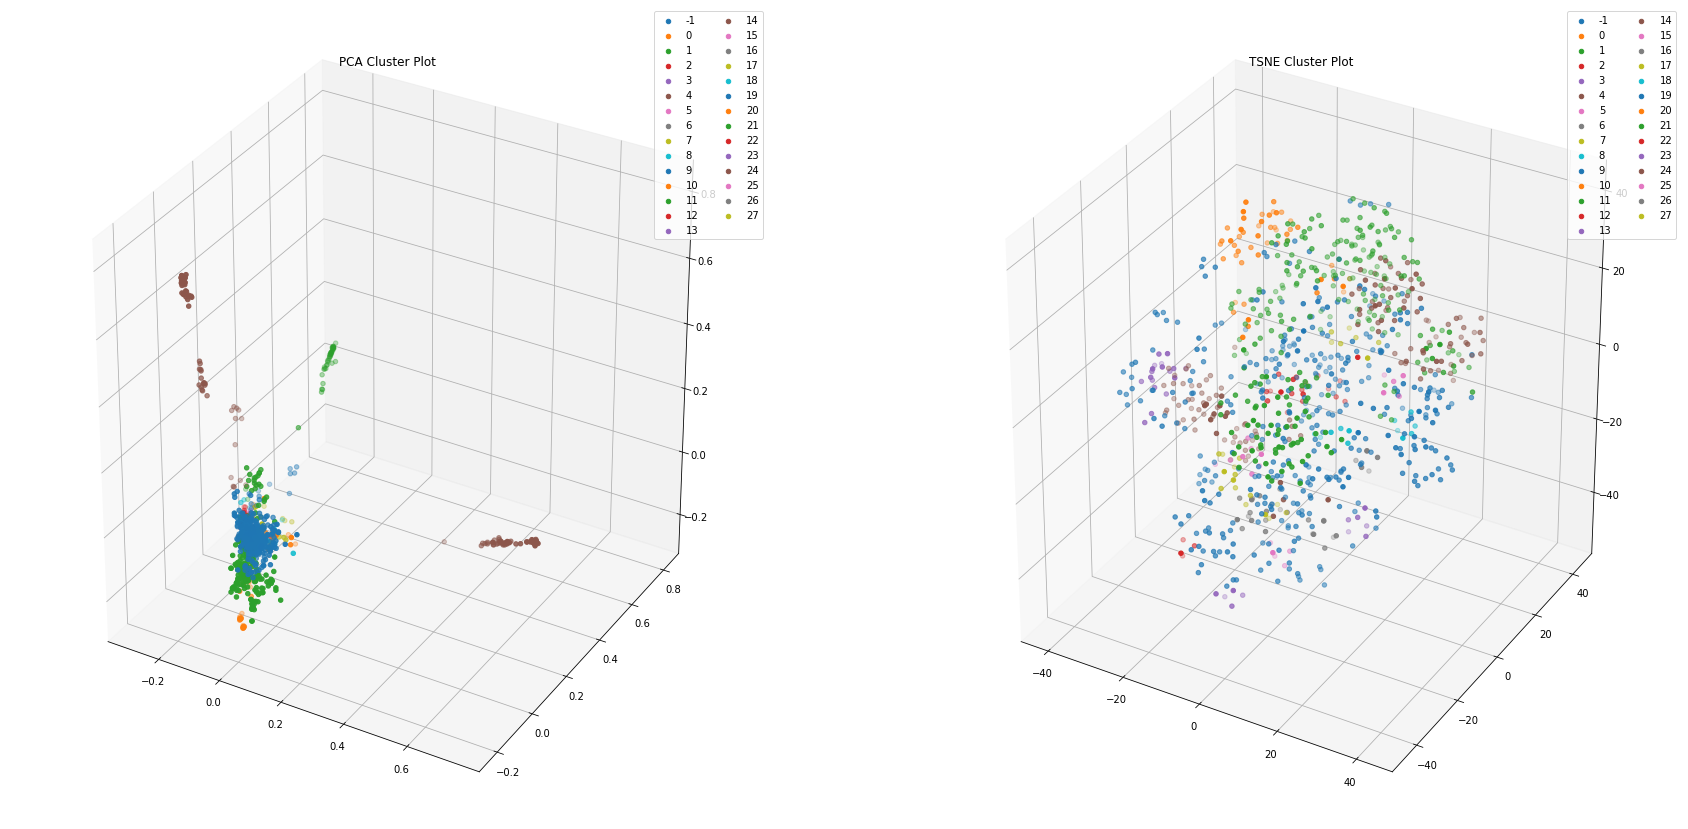

In [ ]:
plot_tsne_pca_lda(X_train, labels, list(set(labels)))
plot_tsne_pca_lda_3d(X_train, labels, list(set(labels)))

In [ ]:
adjusted_rand_score(y_train, labels)

0.14751918326391958

In [ ]:
names = list(get_topics(df_train, labels).values())
class_labels = [list(set([classes[x] for x in df_train[labels==k]['class'].values])) for k in list(set(labels))]
for i in list(set(labels)): print(names[i], class_labels[i])

0 - conference web planning scheduling update ['PS', 'ABD']
1 - exam address student appeal maastricht ['ANLP', 'MAI', 'MIDF', 'Social Dutch', 'Not Important', 'Schedules and Deadlines', 'PS', 'SIP', 'DM', 'MM', 'Exams', 'Information', 'Social', 'ACML', 'DA']
2 - exam proctor student session online ['MM', 'Exams']
3 - incognito link knowledge engineering study ['Incognito']
4 - um measure 1.5 distance face ['Information']
5 - student dke ellen faculty please ['Information', 'Not Important', 'Incognito']
6 - reservation available library cancel book ['Library']
7 - resit exam time collaborate ultra ['MM', 'NM', 'TCS', 'LP']
8 - bonus see answer exam week ['LP']
9 - dke stud pieter documentation Willems Arthur (Stud. DKE) ['MAI']
10 - meeting workshop zoom time password ['MAI']
11 - 20 group dke bianca stud ['MAI']
12 - course ta dke need student ['Not Important']
13 - memoriam op Communicatie (BU) de 2020 ['Not Important']
14 - student feedback course evaluation please ['Not Important',

0.20439957825204264
0.2263180931950889
0.2247557038473406
-0.03305388256686255


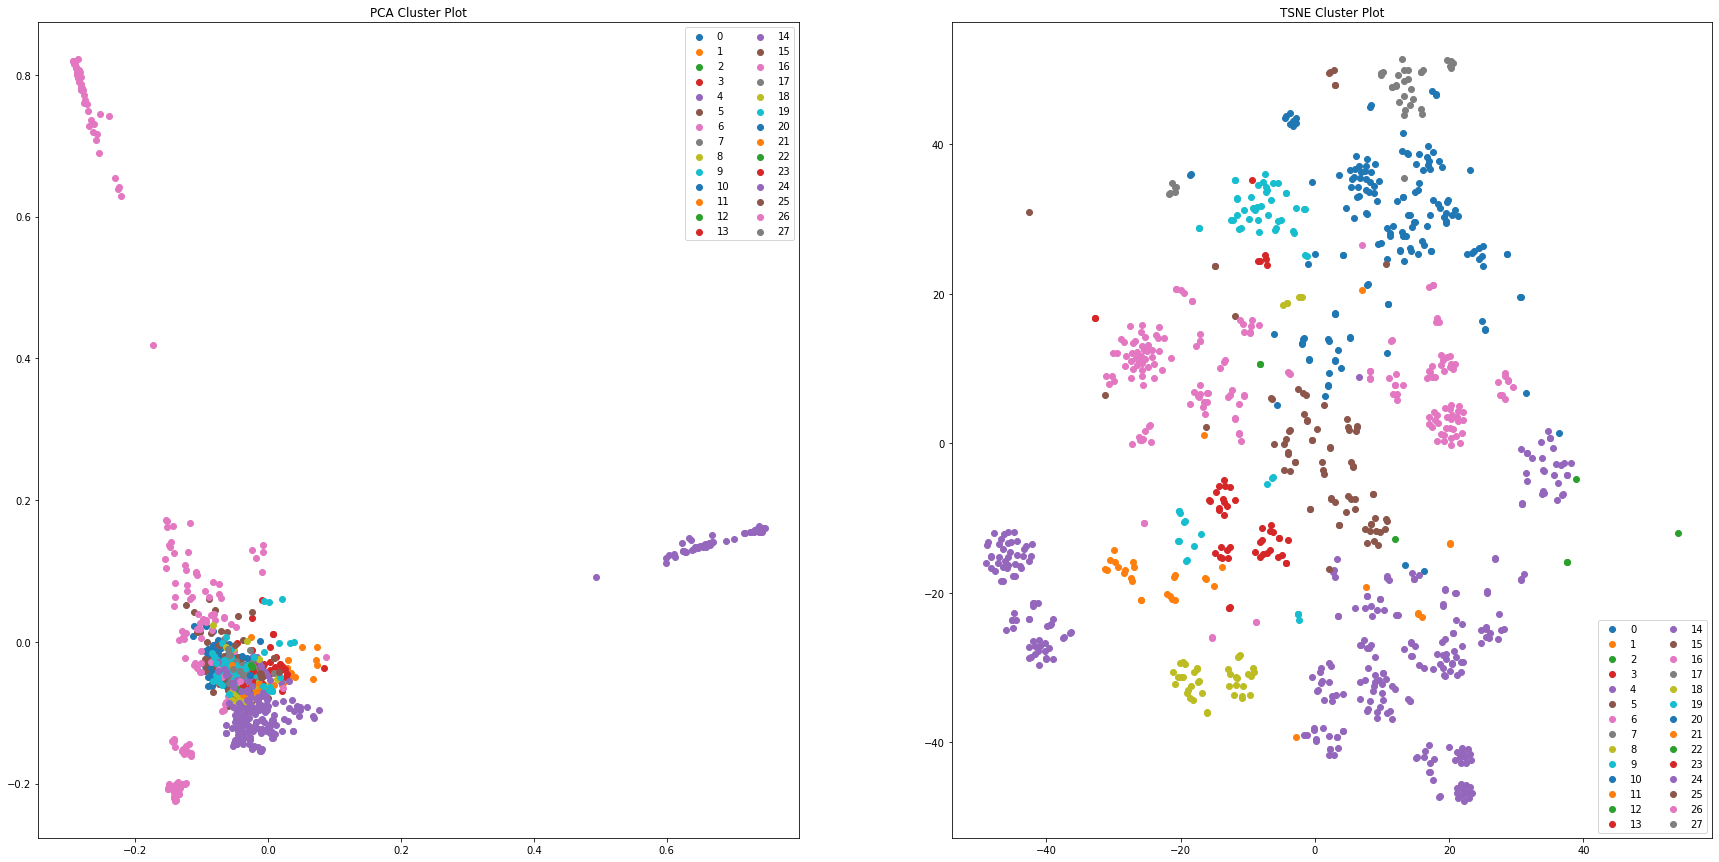

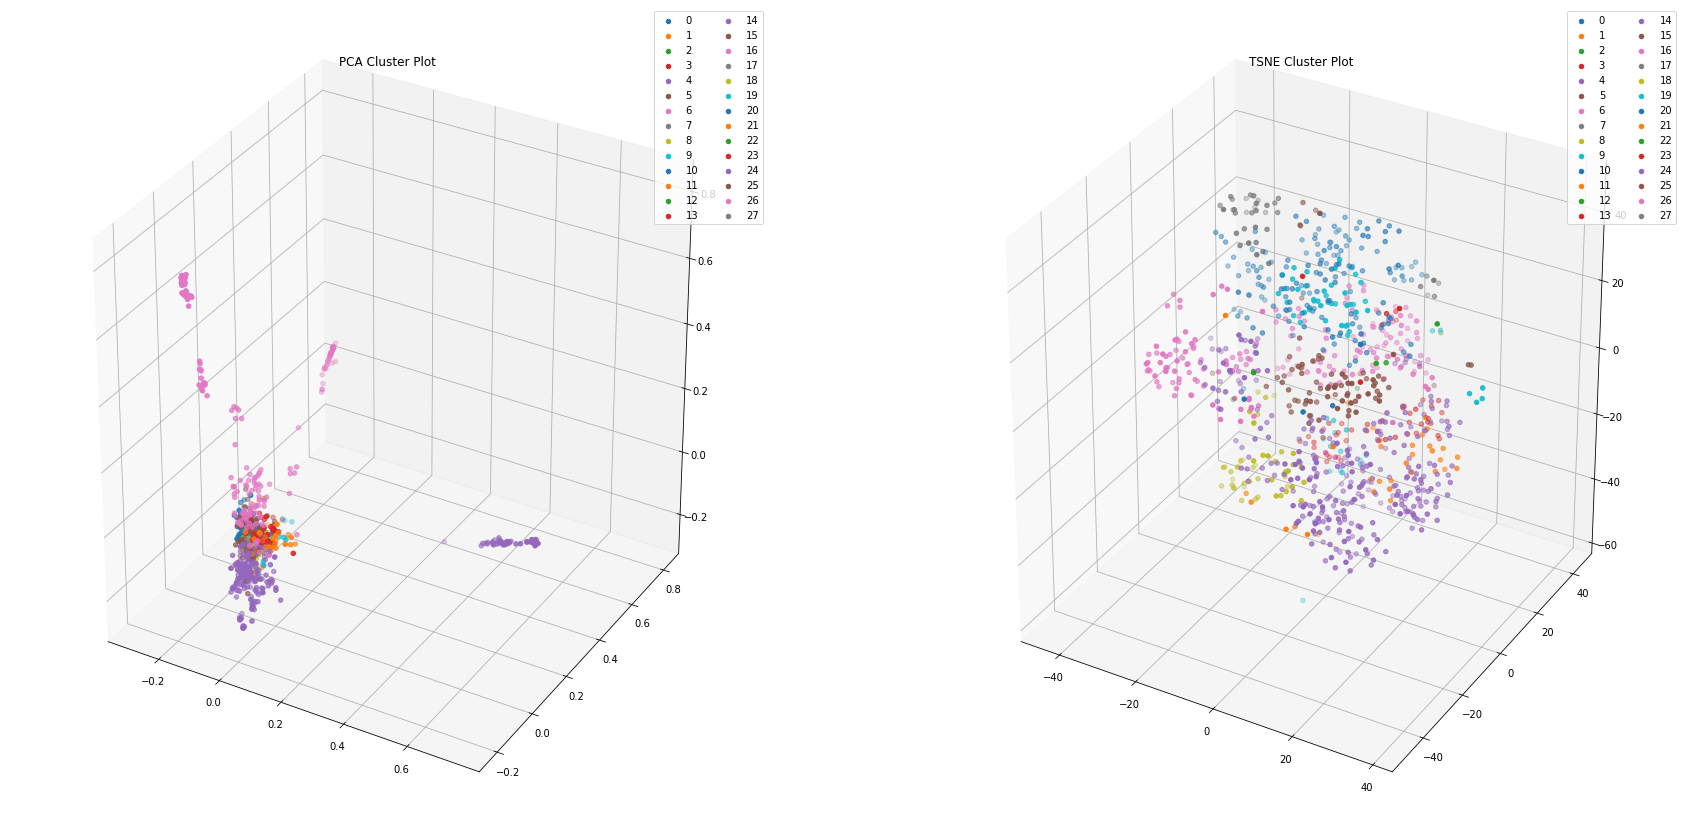

In [ ]:
from sklearn.cluster import AgglomerativeClustering

labels = AgglomerativeClustering(n_clusters=28, affinity='euclidean', linkage='ward').fit_predict(X_train.todense())
print(adjusted_rand_score(y_train, labels))
labels = AgglomerativeClustering(n_clusters=28, affinity='cosine', linkage='average').fit_predict(X_train.todense())
print(adjusted_rand_score(y_train, labels))
labels = AgglomerativeClustering(n_clusters=28, affinity='cosine', linkage='complete').fit_predict(X_train.todense())
print(adjusted_rand_score(y_train, labels))
labels = AgglomerativeClustering(n_clusters=28, affinity='cosine', linkage='single').fit_predict(X_train.todense())
print(adjusted_rand_score(y_train, labels))


labels = AgglomerativeClustering(n_clusters=28, affinity='cosine', linkage='average').fit_predict(X_train.todense())
plot_tsne_pca_lda(X_train, labels, list(set(labels)))
plot_tsne_pca_lda_3d(X_train, labels, list(set(labels)))

In [ ]:
names = list(get_topics(df_train, labels).values())
class_labels = [list(set([classes[x] for x in df_train[labels==k]['class'].values])) for k in list(set(labels))]
for i in list(set(labels)): print(names[i], class_labels[i])

0 - um student maastricht university sender ['UMNews', 'Incognito', 'Social Dutch', 'Not Important', 'Library', 'Social', 'Information', 'UMSports']
1 - project group please student meeting ['ANLP', 'MS', 'MIDF', 'Project - 2-2', 'TCS']
2 - semantic learning graph thesis representation ['Not Important']
3 - exam course time bonus question ['TCS', 'DA', 'Incognito', 'LP']
4 - thesis model use datum abstract ['Not Important']
5 - exam student period dke course ['ABD', 'Not Important', 'Schedules and Deadlines', 'TCS', 'Exams', 'Information', 'ACML']
6 - student exam dke maastricht address ['ANLP', 'Incognito', 'Project - 2-2', 'Not Important', 'Schedules and Deadlines', 'Social', 'Exams', 'Information', 'DA']
7 - de je en het student ['Information', 'UMSports', 'Not Important', 'Social']
8 - dke stud group 20 dear ['MAI']
9 - incognito study dke link event ['Not Important', 'Incognito']
10 - game dke system spatial simulation ['Not Important']
11 - text Koehler Merlin (Stud. DKE) present

Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters
Fit 17 clusters
Fit 18 clusters
Fit 19 clusters
Fit 20 clusters
Fit 21 clusters
Fit 22 clusters
Fit 23 clusters
Fit 24 clusters
Fit 25 clusters
Fit 26 clusters
Fit 27 clusters
Fit 28 clusters
Fit 29 clusters
Fit 30 clusters
Fit 31 clusters
Fit 32 clusters
Fit 33 clusters
Fit 34 clusters
Fit 35 clusters
Fit 36 clusters
Fit 37 clusters
Fit 38 clusters
Fit 39 clusters
Fit 40 clusters
Fit 41 clusters
Fit 42 clusters
Fit 43 clusters
Fit 44 clusters
Fit 45 clusters
Fit 46 clusters
Fit 47 clusters
Fit 48 clusters
Fit 49 clusters
Fit 50 clusters
Fit 51 clusters
Fit 52 clusters
Fit 53 clusters
Fit 54 clusters
Fit 55 clusters
Fit 56 clusters
Fit 57 clusters
Fit 58 clusters
Fit 59 clusters
Fit 60 clusters
Fit 61 clusters
Fit 62 clusters
Fit 63 clusters
Fit 64 clusters


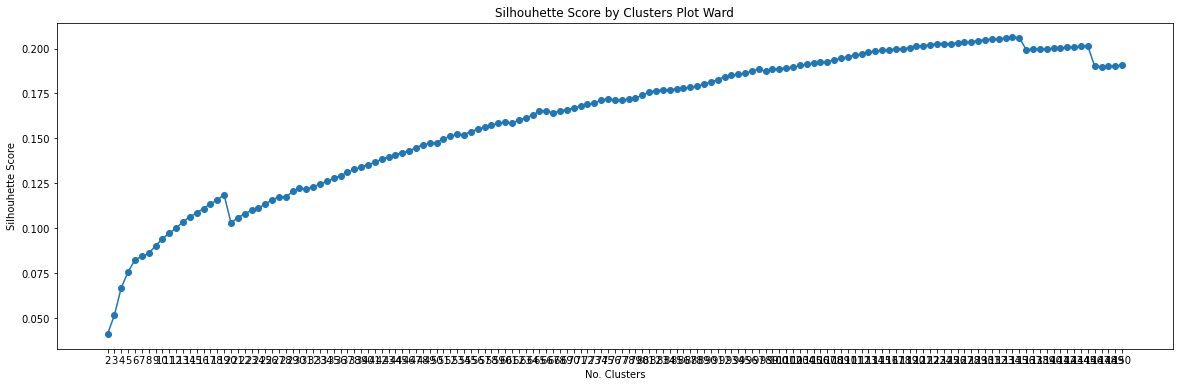

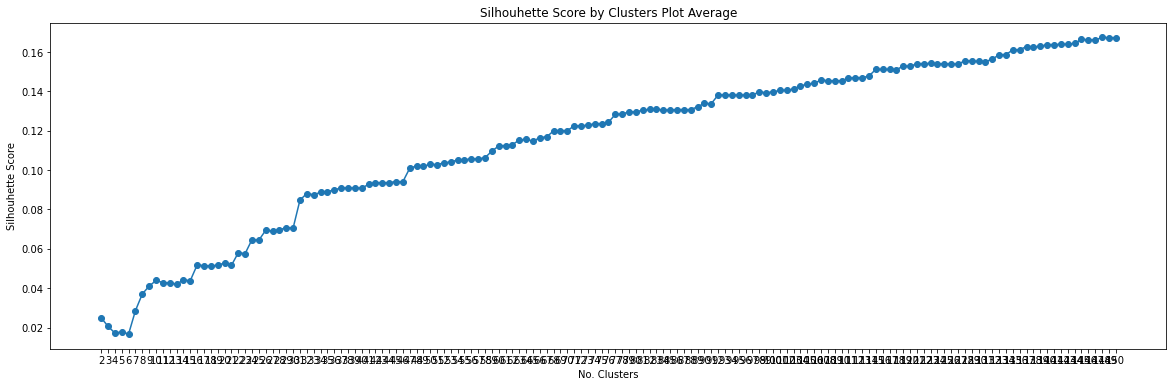

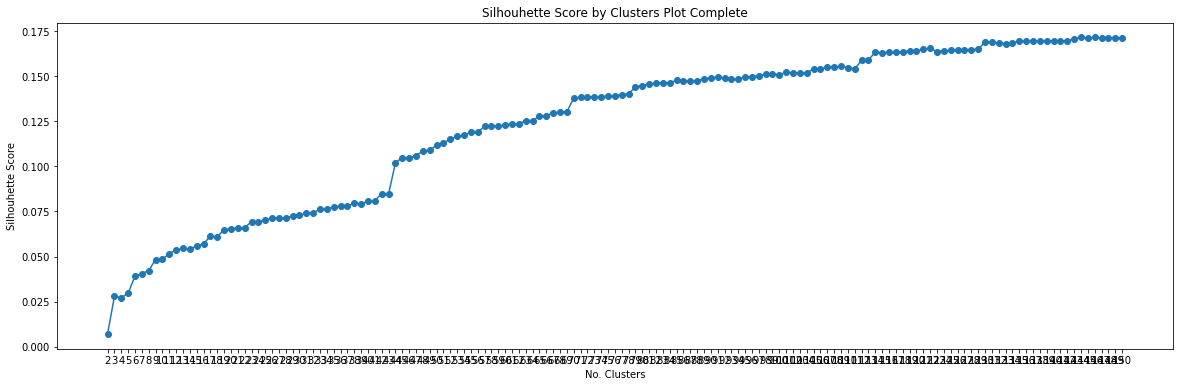

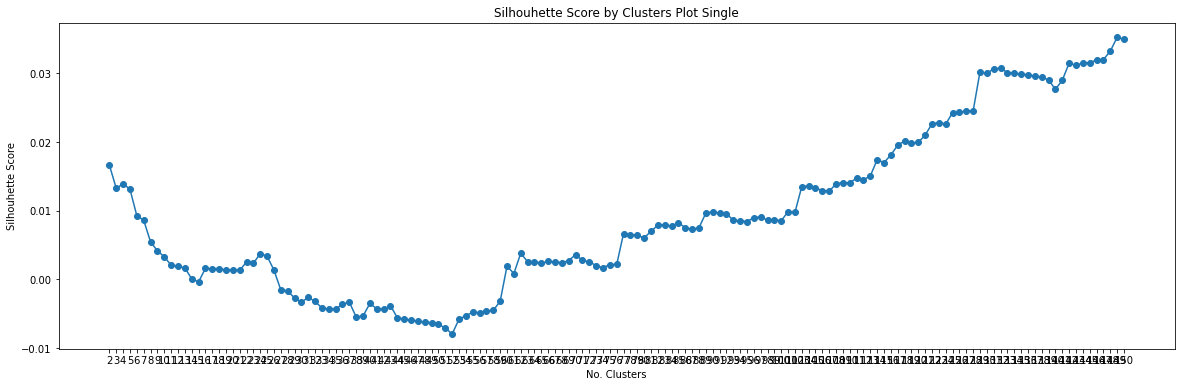

In [10]:
from sklearn.cluster import AgglomerativeClustering
find_optimal_clusters_agglomerative(X_train, 150)